In [727]:
import torch
import math
import numpy as np
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

%matplotlib inline

In [1102]:
x, y = make_blobs(n_samples=2000, n_features=1, centers=3, cluster_std=0.3)

In [1103]:
x = np.squeeze(x)

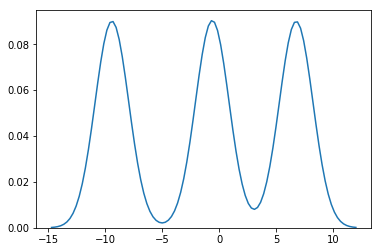

In [1104]:
sns.kdeplot(x)

In [1105]:
mnx = np.mean(x)
sgx = np.std(x)

In [1106]:
x = torch.from_numpy(x).type(torch.float64)
x.requires_grad = False

In [1210]:
#pnorm = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([1.]))
log_p = torch.tensor([math.log(1./3), math.log(1./3), math.log(1./3)]).type(torch.float64).reshape(3, 1)
mu =  torch.tensor([-10, 0, 10]).type(torch.float64).reshape(3, 1)
sigm = torch.tensor([1, 1, 1]).type(torch.float64).reshape(3, 1)

log_q_i = torch.log(torch.from_numpy(np.random.dirichlet((0.5, 0.5, 0.5), 2000).T))
log_q_i.requires_grad = False

log_p.requires_grad = True
mu.requires_grad = True
sigm.requires_grad = True

In [1212]:
def log_likelihood():
    return torch.mean(log_q_i.exp() * (-1/2*torch.log(sigm) - 1/(2 * sigm ** 2) * (x - mu) ** 2 + log_p)) - (torch.exp(log_p).sum() - 1) ** 2

In [1213]:
def logF(x, sigm, mu):
    return -1/2*(math.log(2 * math.pi) - torch.log(sigm)) - 1/(2*sigm**2) * ((x - mu) ** 2)
    
def logE():
    logL = logF(x, sigm, mu) + log_p
    return logL - torch.logsumexp(logL, dim=0, keepdim=True)

In [1216]:
gamma = 0.1

In [1217]:
for i in range(100):
    #print('logL', log_likelihood())
    #print('p', torch.exp(log_p).squeeze())
    #print('mi', mu.squeeze())
    #print('sigm', sigm.squeeze())
    #print('#'*100)
    #print('#'*100)
    
    with torch.no_grad():
        log_q_i = logE()
    
    for j in range(50):
        L = log_likelihood()
        L.backward()

        with torch.no_grad():
            # maximization
            log_p += gamma / 100 * log_p.grad
            mu += gamma * mu.grad
            sigm += gamma * sigm.grad
            # expectation
        log_p.grad = None
        mu.grad = None
        sigm.grad = None
        
        log_p.requires_grad = True
        mu.requires_grad = True
        sigm.requires_grad = True

In [1218]:
print(log_p.exp().squeeze().detach().numpy())
print(mu.squeeze().detach().numpy())
print(sigm.squeeze().detach().numpy())

[0.3814612  0.38138922 0.38128323]
[-9.39555884 -0.5998915   6.75553993]
[0.43318211 0.398093   0.42455279]


In [1219]:
classes = log_q_i.argmax(0).numpy()
x_src = x.numpy()

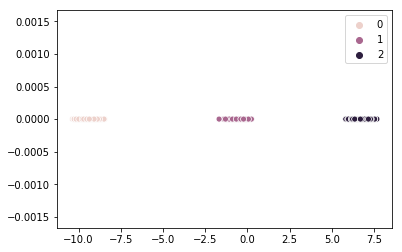

In [1220]:
sns.scatterplot(x_src, np.zeros_like(x_src), classes)